In [1]:
cd c:\\Users\\drake\\Documents\\WGU\\Capstone\\AnalyticsCapstone\\

c:\Users\drake\Documents\WGU\Capstone\AnalyticsCapstone


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from src.data.clean_data import get_batters_df_normalized, get_pitchers_df_normalized, get_batters_df, get_pitchers_df


def compute_silhouette_scores(X, min_k=2, max_k=8, random_state=42):
    scores = []
    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)
    plt.figure(figsize=(8, 4))
    plt.plot(range(min_k, max_k + 1), scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.tight_layout()
    plt.show()
    best_k = int(np.argmax(scores)) + min_k
    print(f'Best number of clusters by silhouette score: {best_k}')
    return best_k, scores


def cluster_and_visualize_value_segments(player_type='batters', n_clusters=None, random_state=42):
    if player_type == 'batters':
        df_norm = get_batters_df_normalized()
        df_raw = get_batters_df()
        war_col = 'b_war'
    elif player_type == 'pitchers':
        df_norm = get_pitchers_df_normalized()
        df_raw = get_pitchers_df()
        war_col = 'p_war'
    else:
        raise ValueError("player_type must be 'batters' or 'pitchers'")
    # Use only numeric columns for clustering
    X = df_norm.dropna(axis=1, how='all').dropna()
    # Align with raw for value calculation
    df_raw = df_raw.loc[X.index]
    # If n_clusters not specified, use silhouette score to find best
    if n_clusters is None:
        best_k, _ = compute_silhouette_scores(X.values)
        n_clusters = int(best_k)
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(X.values)
    X['cluster'] = clusters
    # Compute value metric for labeling
    if war_col in df_raw.columns and 'salary' in df_raw.columns:
        value = df_raw[war_col] / df_raw['salary']
    else:
        value = pd.Series(np.nan, index=df_raw.index)
    X['value'] = value
    # Label clusters by mean value
    cluster_means = X.groupby('cluster')['value'].mean().sort_values(ascending=True)
    labels = {}
    sorted_clusters = list(cluster_means.index)
    for i, cluster in enumerate(sorted_clusters):
        if i == 0:
            labels[cluster] = "Overvalued"
        elif i == n_clusters - 1:
            labels[cluster] = "Undervalued"
        else:
            labels[cluster] = "Fairly Valued"
    X['value_label'] = X['cluster'].map(labels)  # type: ignore
    # --- Cluster profiling ---
    print(f"\nCluster Profiling for {player_type.title()} (mean/std/count):")
    profile_cols = list(X.columns.drop(['cluster', 'value_label']))
    profile = X.groupby('value_label')[profile_cols].agg(['mean', 'std', 'count'])
    print(profile)
    print("\n--- End of Cluster Profiling ---\n")
    # PCA for visualization
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X.drop(['cluster', 'value', 'value_label'], axis=1))
    # Visualization
    plt.figure(figsize=(10, 6))
    colors = {"Overvalued": "red", "Fairly Valued": "gray", "Undervalued": "green"}
    for label, color in colors.items():
        subset = X[X['value_label'] == label]
        plt.scatter(
            X_pca[subset.index, 0],
            X_pca[subset.index, 1],
            label=label,
            alpha=0.7,
            c=color
        )
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"{player_type.title()} Value Segments (PCA, Normalized, k={n_clusters})")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return X



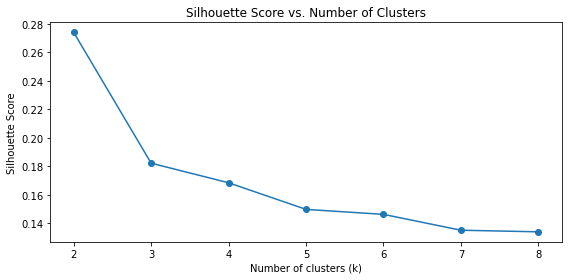

Best number of clusters by silhouette score: 2

Cluster Profiling for Batters (mean/std/count):
                  age                     b_war                   b_games  \
                 mean       std count      mean       std count      mean   
value_label                                                                 
Overvalued   0.513288  0.149497   101  0.200256  0.100052   101  0.566656   
Undervalued  0.470096  0.181761    88  0.372342  0.166460    88  0.883431   

                                 b_pa  ...  b_sf     b_ibb                  \
                  std count      mean  ... count      mean       std count   
value_label                            ...                                   
Overvalued   0.197607   101  0.432095  ...   101  0.033168  0.049131   101   
Undervalued  0.090986    88  0.804657  ...    88  0.124432  0.177303    88   

               salary                         value                      
                 mean       std count          mean  

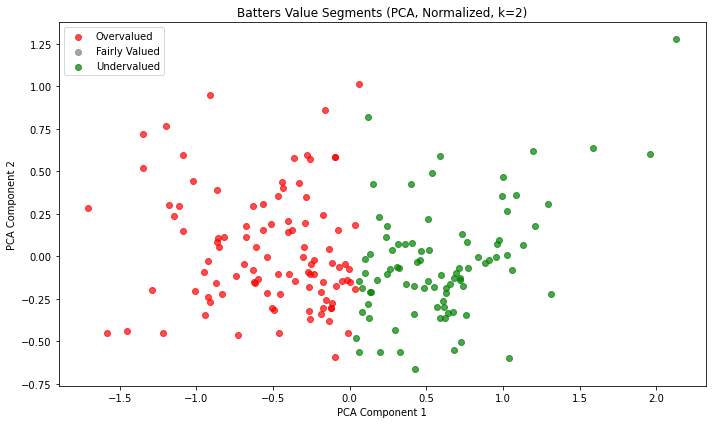

,age,b_war,b_games,b_pa,b_ab,b_r,b_h,b_doubles,b_triples,b_hr,...,b_tb,b_gidp,b_hbp,b_sh,b_sf,b_ibb,salary,cluster,value,value_label
0,0.631579,1.000000,0.974194,0.957592,0.832084,0.909091,0.899497,0.750000,0.071429,1.000000,...,0.953659,0.88,0.409091,0.000,0.2,1.00,0.780833,0,2.700000e-07,Undervalued
1,0.631579,0.153226,0.625806,0.396717,0.386807,0.250000,0.261307,0.208333,0.071429,0.068966,...,0.185366,0.00,0.318182,0.375,0.0,0.00,0.014345,1,1.960784e-07,Overvalued
2,0.315789,0.403226,0.909677,0.867305,0.850075,0.500000,0.713568,0.437500,0.071429,0.327586,...,0.541463,0.36,0.090909,0.000,0.7,0.15,0.093445,0,6.181818e-07,Undervalued
3,0.368421,0.370968,0.877419,0.823529,0.824588,0.454545,0.773869,0.916667,0.142857,0.258621,...,0.602439,0.72,0.272727,0.000,0.6,0.10,0.137278,0,3.896104e-07,Undervalued
4,0.263158,0.290323,0.619355,0.522572,0.503748,0.159091,0.427136,0.395833,0.071429,0.086207,...,0.295122,0.44,0.090909,0.000,0.9,0.05,0.075513,1,4.347826e-07,Overvalued
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.578947,0.225806,0.670968,0.627907,0.635682,0.363636,0.562814,0.312500,0.071429,0.189655,...,0.395122,0.52,0.045455,0.000,0.6,0.00,0.491025,1,4.714286e-08,Overvalued
185,0.631579,0.258065,0.890323,0.844049,0.838081,0.401515,0.788945,0.645833,0.071429,0.241379,...,0.565854,0.48,0.181818,0.000,0.4,0.00,0.143256,0,2.000000e-07,Undervalued
186,0.368421,0.564516,0.903226,0.863201,0.821589,0.651515,0.849246,0.708333,0.142857,0.603448,...,0.760976,0.56,0.454545,0.000,0.4,0.80,0.365744,0,2.817391e-07,Undervalued
187,0.473684,0.153226,0.032258,0.056088,0.053973,0.015152,0.050251,0.062500,0.071429,0.000000,...,0.036585,0.08,0.000000,0.000,0.0,0.00,0.083483,1,6.000000e-08,Overvalued


In [5]:
cluster_and_visualize_value_segments('batters')

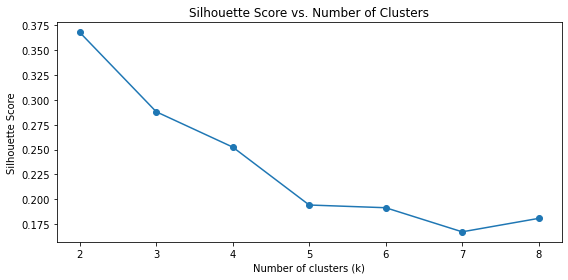

Best number of clusters by silhouette score: 2

Cluster Profiling for Pitchers (mean/std/count):
                  age                     p_war                  \
                 mean       std count      mean       std count   
value_label                                                       
Overvalued   0.444822  0.160702   124  0.302026  0.129996   124   
Undervalued  0.421053  0.185099    77  0.470858  0.236614    77   

            p_win_loss_perc                 p_earned_run_avg  ...  \
                       mean       std count             mean  ...   
value_label                                                   ...   
Overvalued         0.528677  0.265225   124         0.486108  ...   
Undervalued        0.507545  0.155453    77         0.521882  ...   

            p_so_per_nine p_strikeouts_per_base_on_balls                  \
                    count                           mean       std count   
value_label                                                          

IndexError: index 201 is out of bounds for axis 0 with size 201

<Figure size 720x432 with 0 Axes>

In [4]:
cluster_and_visualize_value_segments('pitchers')